# Team Introduction
Our group is comprised of Braden Anderson, Hien Lam, and Tavin Weeda.

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle 

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, multilabel_confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

# Data Preparation Part 1
- Define and prepare your class variables. 
- Use proper variable representations (int, float, one-hot, etc.). 
- Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. 
- Remove variables that are not needed/useful for the analysis.
(10)

## Read, clean the data

In [2]:
# Read in data from github
url_accident = "https://github.com/BradenAnderson/Accident_Severity_Prediction/blob/main/Data/accident.csv.gz?raw=tr"
url_vehicle = "https://github.com/BradenAnderson/Accident_Severity_Prediction/blob/main/Data/vehicle.csv.gz?raw=tr"
url_person = "https://github.com/BradenAnderson/Accident_Severity_Prediction/blob/main/Data/person.csv.gz?raw=tr"

accident = pd.read_csv(url_accident,compression='gzip')
vehicle = pd.read_csv(url_vehicle, compression='gzip', low_memory=False, encoding="ISO-8859-1")
person = pd.read_csv(url_person, compression='gzip', low_memory=False, encoding="ISO-8859-1")

In [3]:
# Filter accidents where driver is present and vehicle is involved
person = person.loc[(person.VEH_NO==1) & (person.PER_NO==1)]
vehicle = vehicle.loc[vehicle.VEH_NO==1]

In [4]:
# Left join person with vehicle and accident
# Duplicated CASENUM are dropped
df = person.merge(vehicle.drop_duplicates(subset=['CASENUM']), on='CASENUM', how='left')
df = df.merge(accident.drop_duplicates(subset=['CASENUM']),on='CASENUM',how='left')

In [5]:
# Comprehensive list of variables used in this analysis
# ORIGINAL features from lab 1 / EDA: regionname, urbanicityname, body_typname, makename, mod_yearname, vtrafwayname, vnum_lanname, vsurcondname, vtrafconname, 
                                # typ_intname, int_hwyname, weathername, wkdy_imname, reljct1_imname, lgtcon_imname, maxsev_imname, alchl_imname, age_im, sex_imname, trav_sp
# DERIVED features: hour_binned, speeding_status
# NEW features post-lab 1 / EDA: rest_usename, pcrash1_imname, weather_binned (binning of `weathername`), body_type_binned (binning of `body_typname`), int_binned (binning of `typ_intname`)
# DISCARDED features that were not useful: hour_imname (unnecessary with `hour_binned`), vspd_lim (unnecessary with `speeding_status`), makename (too many levels), wrk_zonename

df = df[['REGIONNAME','URBANICITYNAME','BODY_TYPNAME_x', 'MOD_YEARNAME_x','VTRAFWAYNAME','VNUM_LANNAME','VSURCONDNAME','VTRAFCONNAME','TYP_INTNAME','INT_HWYNAME','WEATHERNAME',
        'WKDY_IMNAME', 'RELJCT1_IMNAME','LGTCON_IMNAME','MAXSEV_IMNAME','ALCHL_IMNAME','AGE_IM','SEX_IMNAME','TRAV_SP','REST_USENAME','PCRASH1_IMNAME','HOUR_IMNAME','VSPD_LIM',
        'HOUR_IM']]

df = df.rename(columns=str.lower)
df.shape

(54473, 24)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54473 entries, 0 to 54472
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   regionname      54473 non-null  object 
 1   urbanicityname  54473 non-null  object 
 2   body_typname_x  54473 non-null  object 
 3   mod_yearname_x  54473 non-null  object 
 4   vtrafwayname    54427 non-null  object 
 5   vnum_lanname    54427 non-null  object 
 6   vsurcondname    54427 non-null  object 
 7   vtrafconname    54427 non-null  object 
 8   typ_intname     54473 non-null  object 
 9   int_hwyname     54473 non-null  object 
 10  weathername     54473 non-null  object 
 11  wkdy_imname     54473 non-null  object 
 12  reljct1_imname  54473 non-null  object 
 13  lgtcon_imname   54473 non-null  object 
 14  maxsev_imname   54473 non-null  object 
 15  alchl_imname    54473 non-null  object 
 16  age_im          54473 non-null  int64  
 17  sex_imname      54473 non-null 

In [7]:
df.head()

,regionname,urbanicityname,body_typname_x,mod_yearname_x,vtrafwayname,vnum_lanname,vsurcondname,vtrafconname,typ_intname,int_hwyname,...,maxsev_imname,alchl_imname,age_im,sex_imname,trav_sp,rest_usename,pcrash1_imname,hour_imname,vspd_lim,hour_im
0,"West (MT, ID, WA, OR, CA, NV, NM, AZ, UT, CO, ...",Rural Area,"4-door sedan, hardtop",2018,"Two-Way, Not Divided",Five lanes,Snow,Traffic control signal(on colors) not known wh...,Four-Way Intersection,No,...,No Apparent Injury (O),No Alcohol Involved,61,Female,25.0,Shoulder and Lap Belt Used,Going Straight,8:00am-8:59am,98.0,8
1,"South (MD, DE, DC, WV, VA, KY, TN, NC, SC, GA,...",Urban Area,"4-door sedan, hardtop",2013,"Two-Way, Not Divided",Two lanes,Dry,No Controls,Not an Intersection,No,...,Suspected Minor Injury (B),No Alcohol Involved,23,Male,45.0,Shoulder and Lap Belt Used,Going Straight,1:00am-1:59am,25.0,1
2,"South (MD, DE, DC, WV, VA, KY, TN, NC, SC, GA,...",Urban Area,Other or Unknown automobile type,Unknown,"Two-Way, Divided, Unprotected Median",Four lanes,Dry,No Controls,T-Intersection,No,...,No Apparent Injury (O),No Alcohol Involved,27,Female,15.0,Not Reported,Going Straight,1:00pm-1:59pm,45.0,13
3,"West (MT, ID, WA, OR, CA, NV, NM, AZ, UT, CO, ...",Rural Area,"Compact Utility (Utility Vehicle Categories ""S...",2015,"Two-Way, Divided, Positive Median Barrier",Two lanes,Snow,No Controls,Not an Intersection,Yes,...,No Apparent Injury (O),No Alcohol Involved,20,Male,65.0,Shoulder and Lap Belt Used,Going Straight,2:00pm-2:59pm,80.0,14
4,"Northeast (PA, NJ, NY, NH, VT, RI, MA, ME, CT)",Rural Area,Station Wagon (excluding van and truck based),2004,Not Reported,Not Reported,Snow,Warning Sign,Not an Intersection,No,...,No Apparent Injury (O),No Alcohol Involved,23,Male,998.0,Shoulder and Lap Belt Used,Negotiating a Curve,5:00pm-5:59pm,50.0,17


In [8]:
# Check for NA values
df.isnull().sum()

regionname         0
urbanicityname     0
body_typname_x     0
mod_yearname_x     0
vtrafwayname      46
vnum_lanname      46
vsurcondname      46
vtrafconname      46
typ_intname        0
int_hwyname        0
weathername        0
wkdy_imname        0
reljct1_imname     0
lgtcon_imname      0
maxsev_imname      0
alchl_imname       0
age_im             0
sex_imname         0
trav_sp           46
rest_usename       0
pcrash1_imname    46
hour_imname        0
vspd_lim          46
hour_im            0
dtype: int64

In [9]:
df.shape

(54473, 24)

In [10]:
# Remove NA values since they are low representation of the entire dataset
df.dropna(inplace=True)

In [11]:
# Confirm NA values are removed
df.isnull().sum().sum()

0

In [12]:
df.shape

(54427, 24)

### Inspect each feature

#### Year of vehicle **(Continuous)**

In [13]:
# mod_yearname_x
# Remove unknown instances
# Filter to years 1980+
df.mod_yearname_x.value_counts()

2016       3809
2017       3722
2019       3489
2018       3356
Unknown    2935
           ... 
1972          1
1932          1
1953          1
1959          1
1969          1
Name: mod_yearname_x, Length: 67, dtype: int64

In [14]:
df.shape

(54427, 24)

In [15]:
# Remove unknown instances, convert to numeric dtype
non_int_values = pd.to_numeric(df.mod_yearname_x, errors='coerce').isna()
df = df[-non_int_values]
df['mod_yearname_x'] = pd.to_numeric(df['mod_yearname_x'])

In [16]:
# Filter to years 1980+
df = df.loc[df['mod_yearname_x'] >= 1980]

In [17]:
df.shape

(50930, 24)

#### Age of driver **(Continuous)**

In [18]:
# age_im
# Removed observations below 15 years old
# Should we bin 80+ or leave as is?
df = df.loc[df['age_im'] > 15]

In [19]:
df.shape

(50705, 24)

#### Traveling speed of vehicle **(Continuous)**

In [20]:
# trav_sp
# Speed Greater Than 151 mph indicated as 997
# Speed not reported indicated as 998
# Speed reported as unknown indicated as 999
# Discern number of rows lost if 997, 998, and 998 are removed
# 28975 !! Will impute instead
df.loc[df['trav_sp'] >= 997].shape[0]

28975

In [21]:
df.shape

(50705, 24)

#### Sex of driver

In [22]:
# sex_imname
df.sex_imname.value_counts()

Male      31519
Female    19186
Name: sex_imname, dtype: int64

#### Region where crash occurred

- Northeast (PA, NJ, NY, NH, VT, RI, MA, ME, CT)
- West (MT, ID, WA, OR, CA, NV, NM, AZ, UT, CO, WY, AK, HI)
- Midwest (OH, IN, IL, MI, WI, MN, ND, SD, NE, IA, MO, KS)
- South (MD, DE, DC, WV, VA, KY, TN, NC, SC, GA, FL, AL, MS, LA, AR, OK, TX)


In [23]:
# regionname
df.loc[:, "regionname"] = df.loc[:,"regionname"].apply(lambda string: string.split()[0])
df.regionname.value_counts()

South        26481
Midwest       9643
West          8449
Northeast     6132
Name: regionname, dtype: int64

#### Geographical area of the crash

- Urban
- Rural

In [24]:
# urbanicityname
df["urbanicityname"] = df.loc[:,"urbanicityname"].apply(lambda string: string.split()[0])
df.urbanicityname.value_counts()

Urban    37472
Rural    13233
Name: urbanicityname, dtype: int64

#### Trafficway flow just prior to crash

In [25]:
# vtrafwayname
# Bin observations 'Not Reported', 'Reported as Unknown' into NR/UNK
df.vtrafwayname.value_counts()

Two-Way, Not Divided                                     21560
Not Reported                                              8451
Two-Way,  Divided, Positive  Median Barrier               8346
Two-Way, Divided, Unprotected Median                      6455
Two-Way, Not Divided With a Continuous Left-Turn Lane     1860
Non-Trafficway or Driveway Access                         1801
Entrance/Exit Ramp                                        1217
One-Way Trafficway                                         997
Reported as Unknown                                         18
Name: vtrafwayname, dtype: int64

In [26]:
df.shape

(50705, 24)

In [27]:
# Bin observations 'Not Reported', 'Reported as Unknown' into NR/UNK
df['vtrafwayname'] = df['vtrafwayname'].replace(['Not Reported', 'Reported as Unknown'], 'NR/UNK')

# Remove observations 'Not Reported', 'Reported as Unknown'
# remove = ['Not Reported', 'Reported as Unknown']
# df = df[df.vtrafwayname.isin(remove) == False]

In [28]:
df.shape

(50705, 24)

In [29]:
df.vtrafwayname.value_counts()

Two-Way, Not Divided                                     21560
NR/UNK                                                    8469
Two-Way,  Divided, Positive  Median Barrier               8346
Two-Way, Divided, Unprotected Median                      6455
Two-Way, Not Divided With a Continuous Left-Turn Lane     1860
Non-Trafficway or Driveway Access                         1801
Entrance/Exit Ramp                                        1217
One-Way Trafficway                                         997
Name: vtrafwayname, dtype: int64

#### Number of travel lanes just prior to crash. 
- Median: lanes in opposite directions are additive. 
- No median: lanes in traveling direction counts

In [30]:
# vnum_lanname
# Bin 'Not Reported', 'Reported as Unknown' as NR/UNK
df.vnum_lanname.value_counts()

Two lanes                            18000
Not Reported                         14340
Three lanes                           5775
Four lanes                            4714
Five lanes                            3535
Non-Trafficway or Driveway Access     1801
Six lanes                             1200
One lane                               917
Seven or more lanes                    407
Reported as Unknown                     16
Name: vnum_lanname, dtype: int64

In [31]:
# Bin 'Not Reported', 'Reported as Unknown' as NR/UNK
df['vnum_lanname'] = df['vnum_lanname'].replace(['Not Reported', 'Reported as Unknown'], 'NR/UNK')

# Remove observations 'Not Reported', 'Reported as Unknown'
# remove = ['Not Reported', 'Reported as Unknown']
# df = df[df.vnum_lanname.isin(remove) == False]

In [32]:
df.shape

(50705, 24)

In [33]:
df.vnum_lanname.value_counts()

Two lanes                            18000
NR/UNK                               14356
Three lanes                           5775
Four lanes                            4714
Five lanes                            3535
Non-Trafficway or Driveway Access     1801
Six lanes                             1200
One lane                               917
Seven or more lanes                    407
Name: vnum_lanname, dtype: int64

#### Roadway surface condition just prior to crash

In [34]:
# vsurcondname
# Bin 'Not Reported', 'Reported as Unknown', 'Other' as NR/UNK/OTH
df.vsurcondname.value_counts()

Dry                                  37880
Wet                                   6681
Not Reported                          3165
Non-Trafficway or Driveway Access     1801
Snow                                   487
Ice/Frost                              325
Water (Standing or Moving)             102
Slush                                   92
Mud, Dirt or Gravel                     87
Reported as Unknown                     59
Sand                                    15
Other                                    7
Oil                                      4
Name: vsurcondname, dtype: int64

In [35]:
# Bin 'Not Reported', 'Reported as Unknown', 'Other' as NR/UNK/OTH
df['vsurcondname'] = df['vsurcondname'].replace(['Not Reported', 'Reported as Unknown', 'Other'], 'NR/UNK/OTH')

# Remove observations 'Not Reported', 'Reported as Unknown'
# remove = ['Not Reported', 'Reported as Unknown', 'Other']
# df = df[df.vsurcondname.isin(remove) == False]

In [36]:
df.shape

(50705, 24)

In [37]:
df.vsurcondname.value_counts()

Dry                                  37880
Wet                                   6681
NR/UNK/OTH                            3231
Non-Trafficway or Driveway Access     1801
Snow                                   487
Ice/Frost                              325
Water (Standing or Moving)             102
Slush                                   92
Mud, Dirt or Gravel                     87
Sand                                    15
Oil                                      4
Name: vsurcondname, dtype: int64

#### Traffic controls in the vehicle’s environment just prior to crash

In [38]:
# vtrafconname
# Bin 'Not Reported', 'Other Regulatory Sign', 'Other', 'Reported as Unknown', 'Other Highway Traffic Signal', 'Unknown Highway Traffic Signal', 'Unknown Regulatory Sign'
df.vtrafconname.value_counts()

No Controls                                                                     25691
Traffic control signal(on colors) not known whether or not Pedestrian Signal    10520
Not Reported                                                                     7737
Stop Sign                                                                        4768
Yield Sign                                                                        580
Traffic control signal (on colors) with Pedestrian Signal                         520
Warning Sign                                                                      251
Traffic control signal (on colors) without Pedestrian Signal                      183
Flashing Traffic Control Signal                                                   128
Other Regulatory Sign                                                              94
Other                                                                              67
Railway Crossing Device                               

In [39]:
# Bin 'Not Reported', 'Other Regulatory Sign', 'Other', 'Reported as Unknown', 'Other Highway Traffic Signal', 'Unknown Highway Traffic Signal', 'Unknown Regulatory Sign'
df['vtrafconname'] = df['vtrafconname'].replace(['Not Reported', 'Other Regulatory Sign', 'Other', 'Reported as Unknown', 'Other Highway Traffic Signal', 'Unknown Highway Traffic Signal', 'Unknown Regulatory Sign'], 'NR/UNK/OTH')

# Remove observations 'Not Reported', 'Other', 'Reported as Unknown', 'Unknown Highway Traffic Signal', 'Unknown Regulatory Sign'
# remove = ['Not Reported', 'Other', 'Reported as Unknown', 'Unknown Highway Traffic Signal', 'Unknown Regulatory Sign']
# df = df[df.vtrafconname.isin(remove) == False]

In [40]:
df.vtrafconname.value_counts()

No Controls                                                                     25691
Traffic control signal(on colors) not known whether or not Pedestrian Signal    10520
NR/UNK/OTH                                                                       7943
Stop Sign                                                                        4768
Yield Sign                                                                        580
Traffic control signal (on colors) with Pedestrian Signal                         520
Warning Sign                                                                      251
Traffic control signal (on colors) without Pedestrian Signal                      183
Flashing Traffic Control Signal                                                   128
Railway Crossing Device                                                            49
Person                                                                             47
School Zone Sign/Device                               

In [41]:
df.shape

(50705, 24)

#### Did crash occur at intersection

In [42]:
# int_hwyname
# Remove 'Unknown'
df.int_hwyname.value_counts()

No         46035
Yes         4663
Unknown        7
Name: int_hwyname, dtype: int64

In [43]:
# Drop observations with Unknown
df.drop(df[df['int_hwyname'] == 'Unknown'].index, inplace = True)
df.int_hwyname.value_counts()

No     46035
Yes     4663
Name: int_hwyname, dtype: int64

In [44]:
df.shape

(50698, 24)

#### Name of weekday where crash occurred

In [45]:
# wkdy_imname
df.wkdy_imname.value_counts()

Friday       8427
Thursday     7682
Wednesday    7631
Tuesday      7239
Saturday     6986
Monday       6938
Sunday       5795
Name: wkdy_imname, dtype: int64

#### Relation to junction (crash's location with respect to presence in an interchange area)

In [46]:
# reljct1_imname
df.reljct1_imname.value_counts()

No     47293
Yes     3405
Name: reljct1_imname, dtype: int64

#### Lighting condition during time of crash

In [47]:
# lgtcon_imname
df.lgtcon_imname.value_counts()

Daylight                   34052
Dark - Lighted              8468
Dark - Not Lighted          5762
Dusk                        1292
Dawn                         774
Dark - Unknown Lighting      339
Other                         11
Name: lgtcon_imname, dtype: int64

#### Alcohol state of driver

In [48]:
# alchl_imname
df.alchl_imname.value_counts()

No Alcohol Involved    46713
Alcohol Involved        3985
Name: alchl_imname, dtype: int64

In [49]:
df.shape

(50698, 24)

### Newly derived features or careful binning of existing features

#### Speeding status of driver (Braden) (Derived feature)

In [50]:
def create_speeding_feature(row):
    
    # Speed greater than 151 mph, you're speeding
    if row["trav_sp"] == 997:
        return 'speeding'
    
    # If we know they were going 95 mph or faster, calling that speeding
    # regardless of what the speed limit is, or if we even know ths speed limit.
    elif row["trav_sp"] < 152 and row["trav_sp"] >= 95:
        return 'speeding'
    
    # If the speed limit is unknown, speeding is unknown
    elif row["vspd_lim"] == 98 or row["vspd_lim"] == 99:
        return 'unknown'
    
    # If the traveling speed is unknown, speeding is unknown
    elif row['trav_sp'] == 998 or row['trav_sp'] == 999:
        return 'unknown'
    
    # If traveling faster than the speed limit, speeding
    elif row['trav_sp'] > row['vspd_lim']:
        return 'speeding'
    else:
        return 'not speeding'
    
df["speeding_status"] = df.apply(lambda row: create_speeding_feature(row), axis='columns')

#### Time of accident, hours binned (Braden) (Derived feature)

- Morning (6am-noon)
- Afternoon (noon-6pm)
- Evening (6pm-midnight)
- Night (midnight-6am)']

In [51]:
# code here
def create_binned_hours_feature(numeric_hour, night_hours=[0,1,2,3,4,21,22,23], morning_hours=[5,6,7,8,9,10,11], 
                                afternoon_hours=[12,13,14,15], evening_hours=[16,17,18,19,20]):
    
    # NOTE: numeric_hour is a value from the HOUR_IM column

    # Default for night is 9pm-4:59am
    if numeric_hour in night_hours:
        return "Night"
    
    # Default for morning is 5am-11:59am
    elif numeric_hour in morning_hours:
        return "Morning"
    
    # Default for Afternoon is 12:00pm-3:59pm
    elif numeric_hour in afternoon_hours:
        return "Afternoon"
    
    # Default for evening is 4:00pm-8:59pm
    elif numeric_hour in evening_hours:
        return "Evening"
    
df["hour_binned"] = df["hour_im"].apply(lambda hour: create_binned_hours_feature(numeric_hour=hour))

# After hour_im is used to create hour_binned, we no longer need hour_im
df.drop(columns="hour_im", inplace=True)

#### Body type of vehicle (Tavin) (Careful binning)

In [52]:
# code here

#### Type of intersection (Careful binning)

In [53]:
df.typ_intname.value_counts()

Not an Intersection        28229
Four-Way Intersection      12518
T-Intersection              5235
Not Reported                4201
Y-Intersection               161
Five Point, or More          152
Roundabout                   139
Traffic Circle                34
L-Intersection                21
Other Intersection Type        6
Reported as Unknown            2
Name: typ_intname, dtype: int64

In [54]:
df.columns

Index(['regionname', 'urbanicityname', 'body_typname_x', 'mod_yearname_x',
       'vtrafwayname', 'vnum_lanname', 'vsurcondname', 'vtrafconname',
       'typ_intname', 'int_hwyname', 'weathername', 'wkdy_imname',
       'reljct1_imname', 'lgtcon_imname', 'maxsev_imname', 'alchl_imname',
       'age_im', 'sex_imname', 'trav_sp', 'rest_usename', 'pcrash1_imname',
       'hour_imname', 'vspd_lim', 'speeding_status', 'hour_binned'],
      dtype='object')

In [55]:
def intersection_category(row):
    if row == 'Not an Intersection':
        result = 'No'
    elif row == 'Reported as Unknown':
        result = 'Other'
    elif row == 'Not Reported':
        result = 'Other'
    else:
        result = 'Yes'
    return result

df['intersection_binned'] = df['typ_intname'].apply(intersection_category)
df.intersection_binned.value_counts()

No       28229
Yes      18266
Other     4203
Name: intersection_binned, dtype: int64

#### Weather during time of crash (Careful binning)

In [56]:
# weathername
df.weathername.value_counts()

Clear                       35486
Cloudy                       6769
Rain                         4689
Not Reported                 2569
Snow                          752
Fog, Smog, Smoke              216
Reported as Unknown            70
Severe Crosswinds              46
Blowing Snow                   33
Sleet or Hail                  29
Freezing Rain or Drizzle       19
Other                          17
Blowing Sand, Soil, Dirt        3
Name: weathername, dtype: int64

In [57]:
def weather_cat(row):
    if row == 'Cloudy':
        return 'Not Clear'
    elif row == 'Fog, Smog, Smoke':
        return 'Not Clear' 
    elif row == 'Snow':
        return 'Wintery'
    elif row == 'Blowing Snow':
        return 'Wintery'
    elif row == 'Sleet or Hail':
        return 'Wintery'
    elif row == 'Freezing Rain or Drizzle':
        return 'Wintery'
    elif row == 'Severe Crosswinds':
        return 'Windy'
    elif row == 'Blowing Sand, Soil, Dirt':
        return 'Windy'
    elif row == 'Clear':
        return 'Clear'
    elif row == 'Rain':
        return 'Rain'
    else:
        return 'Other'
df['weather_binned'] = df['weathername'].apply(weather_cat)
df.weather_binned.value_counts()

Clear        35486
Not Clear     6985
Rain          4689
Other         2656
Wintery        833
Windy           49
Name: weather_binned, dtype: int64

#### Restraint use by driver (Newly added feature)

In [58]:
# rest_use
df.rest_usename.value_counts()

Shoulder and Lap Belt Used       40587
None Used/Not Applicable          4735
Reported as Unknown               3221
Not Reported                      1297
Lap Belt Only Used                 418
Shoulder Belt Only Used            331
Restraint Used - Type Unknown      104
Other                                5
Name: rest_usename, dtype: int64

In [59]:
# rest_use: bin into none, minimal, full, other
def restraint_category(row):
    if row == 'Shoulder and Lap Belt Used':
        result = 'Full'
    elif row == 'None Used/Not Applicable':
        result = 'None'    
    elif row == 'Lap Belt Only Used':
        result = 'Minimal'
    elif row == 'Shoulder Belt Only Used':
        result = 'Minimal'
    elif row == 'Restraint Used - Type Unknown':
        result = 'Minimal'
    else:
        result = 'Other'
    return result

df['restraint_binned'] = df['rest_usename'].apply(restraint_category)
df.restraint_binned.value_counts()

Full       40587
None        4735
Other       4523
Minimal      853
Name: restraint_binned, dtype: int64

#### What driver was doing right before crash (Newly added feature)

In [60]:
# pcrash1_imname
df.pcrash1_imname.value_counts()

Going Straight                                                28172
Turning Left                                                   7056
Negotiating a Curve                                            4199
Changing Lanes                                                 2779
Turning Right                                                  2593
Stopped in Roadway                                             1268
Decelerating in Road                                           1102
Backing Up (other than for Parking Position)                    926
Passing or Overtaking Another Vehicle                           726
Starting in Road                                                639
Making a U-turn                                                 454
Merging                                                         265
Leaving a Parking Position                                      169
Entering a Parking Position                                     112
Accelerating in Road                            

#### **Response variable:** Maximum injury severity of driver (Careful binning)

In [61]:
# maxsev_imname
df.maxsev_imname.value_counts()

No Apparent Injury (O)          22490
Possible Injury (C)             11649
Suspected Minor Injury (B)       9012
Suspected Serious Injury (A)     6037
Fatal Injury (K)                 1347
Injured, Severity Unknown         162
Died Prior to Crash*                1
Name: maxsev_imname, dtype: int64

In [62]:
# Remove Injured, Severity Unknown and Died Prior to Crash 
remove = ['Injured, Severity Unknown', 'Died Prior to Crash*']
df = df[df.maxsev_imname.isin(remove) == False]
df['maxsev_imname'] = df['maxsev_imname'].str[:-4]
df.maxsev_imname.value_counts()

No Apparent Injury          22490
Possible Injury             11649
Suspected Minor Injury       9012
Suspected Serious Injury     6037
Fatal Injury                 1347
Name: maxsev_imname, dtype: int64

In [63]:
# Combine No Apparent Injury, Possible Injury, Suspected Minor Injury into one bin
# Combine Suspected Serious Injury and Fatal Injury into one bin
df['maxsev_binned'] = df['maxsev_imname'].replace(to_replace={'Suspected Serious Injury':'Fatal', 
                                                              'Fatal Injury':'Fatal', 
                                                              'No Apparent Injury':'Not Fatal', 
                                                              'Possible Injury':'Not Fatal', 
                                                              'Suspected Minor Injury':'Not Fatal'})
df.maxsev_binned.value_counts()

Not Fatal    43151
Fatal         7384
Name: maxsev_binned, dtype: int64

### End of data cleaning. Review final dataset

In [64]:
# Remove features that are not useful for modeling or redundant post binning
df = df[df.columns.difference(['body_typname_x', 'typ_intname', 'weathername', 'rest_usename', 'hour_imname', 'vspd_lim'])]

In [65]:
# Check for duplicates
# Recall duplicated casenum was taken cared of during merge
# Here we check for duplicates of instances excluding `casenum`
df.duplicated().sum()

1

In [66]:
# Confirm there are zero NA values
df.isnull().sum().sum()

0

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50535 entries, 0 to 54471
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age_im               50535 non-null  int64  
 1   alchl_imname         50535 non-null  object 
 2   hour_binned          50535 non-null  object 
 3   int_hwyname          50535 non-null  object 
 4   intersection_binned  50535 non-null  object 
 5   lgtcon_imname        50535 non-null  object 
 6   maxsev_binned        50535 non-null  object 
 7   maxsev_imname        50535 non-null  object 
 8   mod_yearname_x       50535 non-null  int64  
 9   pcrash1_imname       50535 non-null  object 
 10  regionname           50535 non-null  object 
 11  reljct1_imname       50535 non-null  object 
 12  restraint_binned     50535 non-null  object 
 13  sex_imname           50535 non-null  object 
 14  speeding_status      50535 non-null  object 
 15  trav_sp              50535 non-null 

In [68]:
display(df)

,age_im,alchl_imname,hour_binned,int_hwyname,intersection_binned,lgtcon_imname,maxsev_binned,maxsev_imname,mod_yearname_x,pcrash1_imname,...,sex_imname,speeding_status,trav_sp,urbanicityname,vnum_lanname,vsurcondname,vtrafconname,vtrafwayname,weather_binned,wkdy_imname
0,61,No Alcohol Involved,Morning,No,Yes,Daylight,Not Fatal,No Apparent Injury,2018,Going Straight,...,Female,unknown,25.0,Rural,Five lanes,Snow,Traffic control signal(on colors) not known wh...,"Two-Way, Not Divided",Not Clear,Wednesday
1,23,No Alcohol Involved,Night,No,No,Dark - Not Lighted,Not Fatal,Suspected Minor Injury,2013,Going Straight,...,Male,speeding,45.0,Urban,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Clear,Wednesday
3,20,No Alcohol Involved,Afternoon,Yes,No,Daylight,Not Fatal,No Apparent Injury,2015,Going Straight,...,Male,not speeding,65.0,Rural,Two lanes,Snow,No Controls,"Two-Way, Divided, Positive Median Barrier",Wintery,Wednesday
4,23,No Alcohol Involved,Evening,No,No,Dark - Not Lighted,Not Fatal,No Apparent Injury,2004,Negotiating a Curve,...,Male,unknown,998.0,Rural,NR/UNK,Snow,Warning Sign,NR/UNK,Wintery,Wednesday
5,57,No Alcohol Involved,Evening,No,No,Dark - Not Lighted,Not Fatal,Possible Injury,2003,Going Straight,...,Female,unknown,998.0,Rural,NR/UNK,Dry,No Controls,NR/UNK,Clear,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54467,61,No Alcohol Involved,Afternoon,No,No,Daylight,Not Fatal,No Apparent Injury,2017,Going Straight,...,Female,unknown,998.0,Rural,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Clear,Monday
54468,70,No Alcohol Involved,Evening,No,No,Daylight,Not Fatal,Suspected Minor Injury,2019,Going Straight,...,Male,unknown,998.0,Rural,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Not Clear,Wednesday
54469,59,No Alcohol Involved,Evening,No,No,Dark - Not Lighted,Not Fatal,Possible Injury,1999,Negotiating a Curve,...,Male,unknown,998.0,Urban,Two lanes,Dry,NR/UNK/OTH,"Two-Way, Not Divided",Clear,Thursday
54470,67,No Alcohol Involved,Morning,No,No,Daylight,Not Fatal,Suspected Minor Injury,2006,Going Straight,...,Male,unknown,998.0,Urban,Two lanes,Dry,NR/UNK/OTH,"Two-Way, Not Divided",Clear,Tuesday


## Begin data preprocessing

In [69]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["maxsev_binned"])

In [70]:
# code to scale features
scaler = StandardScaler()

# Fit the scaler on the training set age column, and transform (scale) the training set age column
train_df.loc[:, ["age_im"]] = scaler.fit_transform(X=train_df.loc[:, ["age_im"]])

# Using means and standard deviations from training set, scale the test set
test_df.loc[:, ["age_im"]] = scaler.transform(X=test_df.loc[:, ["age_im"]])

In [71]:
# code for one hot encode
features_to_ohe = ["hour_binned", "intersection_binned", "lgtcon_imname", "pcrash1_imname", "regionname", 
                   "restraint_binned", "vtrafconname", "vtrafwayname", "weather_binned", "wkdy_imname", 
                   "vnum_lanname", "vsurcondname", "speeding_status"]

# Features that need to become binary
binary_features = ["urbanicityname", "alchl_imname", "reljct1_imname", "int_hwyname", "sex_imname"]

# List of all the features that are not being converted to binary, or being OneHotEncoder
# (Just a list of all features not in either of the two lists above).
non_encoded_features = [col for col in df.columns if col not in features_to_ohe + binary_features]

# Map each soon to be binary feature to its two initial values
binary_encoding_map = {feature:df[feature].unique().tolist() for feature in binary_features}

# Instantiate the OrdinalEncoder that will create the binary columns
ord_encoder = OrdinalEncoder(categories=[value for value in binary_encoding_map.values()])

# Map each feature that will be OneHotEncoded to a list of all possible categories that feature can take on. 
oridnal_encoding_map = {feature:df[feature].unique().tolist() for feature in features_to_ohe}

# Instantiate the OneHotEncoder, telling it what the possible categories are for each feature.
oh_encoder = OneHotEncoder(categories=[value for value in oridnal_encoding_map.values()]) 

encoders = ColumnTransformer(transformers=[("ordinal_encoder", ord_encoder, binary_features), 
                                           ("one_hot_encoder", oh_encoder, features_to_ohe)], 
                             remainder="passthrough",
                             sparse_threshold=0,
                             n_jobs=-1)

# Create a dataframe of all the encoded columns in the training set
train_encoded_features = pd.DataFrame(encoders.fit_transform(train_df.drop(columns=non_encoded_features)), 
                                      columns=encoders.get_feature_names_out())

# Remove the non-encoded versions, and add in the encoded-versions of all columns.
# Creates a version of the training set where all columns that need to be encoded are now encoded.
train_encoded_df = pd.concat(objs=[train_df.drop(columns=features_to_ohe+binary_features).reset_index(drop=True), 
                                   train_encoded_features.reset_index(drop=True)], 
                             axis='columns')

# Create a dataframe of all encoded (one hot and ordinal) columns for the test set
test_encoded_features = pd.DataFrame(encoders.transform(test_df.drop(columns=non_encoded_features)), 
                                     columns=encoders.get_feature_names_out())

# Remove the non-encoded versions, and add in the encoded-versions of all columns.
# Creates a version of the test set where all columns that need to be encoded are now encoded.
test_encoded_df = pd.concat(objs=[test_df.drop(columns=features_to_ohe+binary_features).reset_index(drop=True), 
                                   test_encoded_features.reset_index(drop=True)], 
                             axis='columns')

#### Imputing travel speed

In [72]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Set the placeholder values (which need to be imputed) to NaN
train_encoded_df.loc[train_encoded_df["trav_sp"].isin([997, 998, 999]), "trav_sp"] = np.nan
test_encoded_df.loc[test_encoded_df["trav_sp"].isin([997, 998, 999]), "trav_sp"] = np.nan

# Set up version of training dataset to be used for imputing trav_sp
imputer_train_df = train_encoded_df.copy(deep=True)
imputer_train_df.drop(columns=["maxsev_binned"], inplace=True)
severity_ord_enc = OrdinalEncoder(categories=[["No Apparent Injury", "Possible Injury", "Suspected Minor Injury", "Suspected Serious Injury", "Fatal Injury"]])
imputer_train_df["maxsev_imname"] = severity_ord_enc.fit_transform(X=imputer_train_df["maxsev_imname"].to_numpy().reshape(-1,1))

# Setting the minimum and maximum value the imputer can impute for a traveling speed. 
min_trav_sp = 15
max_trav_sp = 151
impute_min_values = [-np.inf if col != "trav_sp" else min_trav_sp for col in imputer_train_df.columns]
impute_max_values = [np.inf if col != "trav_sp" else max_trav_sp for col in imputer_train_df.columns]

# Instantiate the iterative imputer
imputer = IterativeImputer(min_value=impute_min_values, 
                           max_value=impute_max_values,
                           random_state=42)

# Fit the iterative imputer on the training set, and impute the training set
imputer_train_result = imputer.fit_transform(X=imputer_train_df)

# Take the output of running iteratrive imputer on the train set, and convert it to a dataframe
# Save the imputed version of traveling speed to train_encoded_df
imputer_train_result_df = pd.DataFrame(imputer_train_result, 
                                       columns=imputer.get_feature_names_out())
train_encoded_df["trav_sp_imputed"] = imputer_train_result_df["trav_sp"]

# Set up the version of the test dataset that will run through the imputer
imputer_test_df = test_encoded_df.copy(deep=True)
imputer_test_df.drop(columns=["maxsev_binned"], inplace=True)
imputer_test_df["maxsev_imname"] = severity_ord_enc.transform(X=imputer_test_df["maxsev_imname"].to_numpy().reshape(-1,1))

# Run the test data through the imputer
imputer_test_result = imputer.transform(X=imputer_test_df)

# Convert the output of running the test data through iterative imputer to a dataframe
imputer_test_result_df = pd.DataFrame(imputer_test_result, 
                                      columns=imputer.get_feature_names_out())
test_encoded_df["trav_sp_imputed"] = imputer_test_result_df["trav_sp"]

In [73]:
# Dropping the Non-Imputed versions of travel speed, now that imputation has been performed
train_imputed_df = train_encoded_df.drop(columns="trav_sp")
test_imputed_df = test_encoded_df.drop(columns="trav_sp")

#### Scaling travel speed

In [74]:
speed_scaler = StandardScaler()

# Fit and transform the scaler on the training set
train_imputed_df["trav_sp_scaled"] = speed_scaler.fit_transform(train_imputed_df["trav_sp_imputed"].to_numpy().reshape(-1,1))

# Only transform on the test set (no data leakage)
test_imputed_df["trav_sp_scaled"] = speed_scaler.transform(test_imputed_df["trav_sp_imputed"].to_numpy().reshape(-1,1))

# Use these dataframes moving forward
# The final, fully preprocessed dataframes (all features encoded and imputed as needed)
# Using "pp" to stand for preprocessed
train_pp_df = train_imputed_df.drop(columns="trav_sp_imputed")
test_pp_df = test_imputed_df.drop(columns="trav_sp_imputed")

In [75]:
train_pp_df.head()

,age_im,maxsev_binned,maxsev_imname,mod_yearname_x,ordinal_encoder__urbanicityname,ordinal_encoder__alchl_imname,ordinal_encoder__reljct1_imname,ordinal_encoder__int_hwyname,ordinal_encoder__sex_imname,one_hot_encoder__hour_binned_Morning,...,one_hot_encoder__vsurcondname_Ice/Frost,one_hot_encoder__vsurcondname_Water (Standing or Moving),one_hot_encoder__vsurcondname_Slush,one_hot_encoder__vsurcondname_Sand,"one_hot_encoder__vsurcondname_Mud, Dirt or Gravel",one_hot_encoder__vsurcondname_Oil,one_hot_encoder__speeding_status_unknown,one_hot_encoder__speeding_status_speeding,one_hot_encoder__speeding_status_not speeding,trav_sp_scaled
0,2.530925,Not Fatal,Suspected Minor Injury,2015,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.576041
1,0.194944,Not Fatal,No Apparent Injury,1997,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.028842
2,1.961173,Not Fatal,No Apparent Injury,2016,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.927596
3,0.365870,Not Fatal,No Apparent Injury,2018,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.778951
4,-0.602708,Not Fatal,No Apparent Injury,2008,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.275314


In [76]:
# table of features with representation (int, float, one-hot)
# will do after braden does OHE

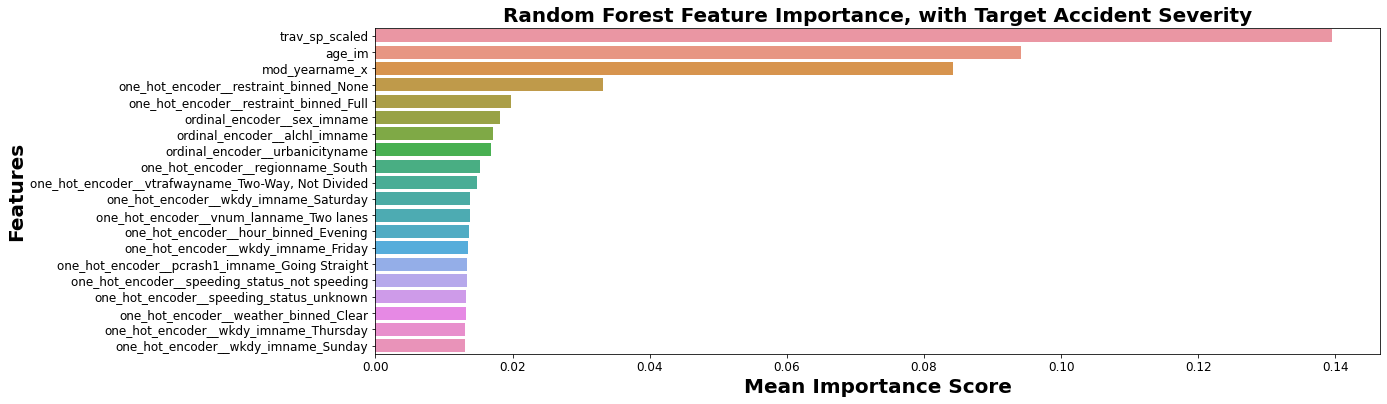

In [77]:
# code for feature selection: random forest feature importance

# We will plot importances for the top NUM_IMPORTANCES_TO_PLOT features (by mean score)
# This will be used for rf, selectkbest and mutualinfo
NUM_IMPORTANCES_TO_PLOT = 20

# Split the train set into X and y
X = train_pp_df.drop(columns=["maxsev_binned", "maxsev_imname"])
y = train_pp_df.loc[:, "maxsev_binned"]

# Instantiate and fit the random forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Calculates the standard deviation of the importance score for each feature.
# For each of the 100 trees in the random forest, get the importance scores for all 106 features.
# Then take the standard deviation of those 100 scores for each of the 106 features.
# Result is 106 standard deviations, where each standard deviation was calculated from 100 values. 
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
rf_importance_stds = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Create a dataframe of importance scores
rf_importances_df = pd.DataFrame({"feature_name":rf.feature_names_in_, 
                                  "mean_importance_score":rf.feature_importances_, 
                                  "std_importance_score":rf_importance_stds})

# Sort the dataframe, largest to smallest mean score
rf_importances_df.sort_values(by="mean_importance_score", ascending=False, inplace=True)

# reset the index so it starts back at 1, don't keep the old index as a column
rf_importances_df.reset_index(drop=True, inplace=True)

# Create a truncated version of the dataframe containing only the first NUM_IMPORTANCES_TO_PLOT rows
rf_plot_df = rf_importances_df.loc[rf_importances_df.index < NUM_IMPORTANCES_TO_PLOT, :]

# Create a horizontal bar plot of importance scores
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
sns.barplot(y="feature_name", x="mean_importance_score", data=rf_plot_df, ax=ax, orient="h")

ax.set_title("Random Forest Feature Importance, with Target Accident Severity", fontsize=20, weight=1000)
ax.set_xlabel("Mean Importance Score", size=20, weight=1_000)
ax.set_ylabel("Features", size=20, weight=1_000)
ax.tick_params(axis='both', labelsize=12)

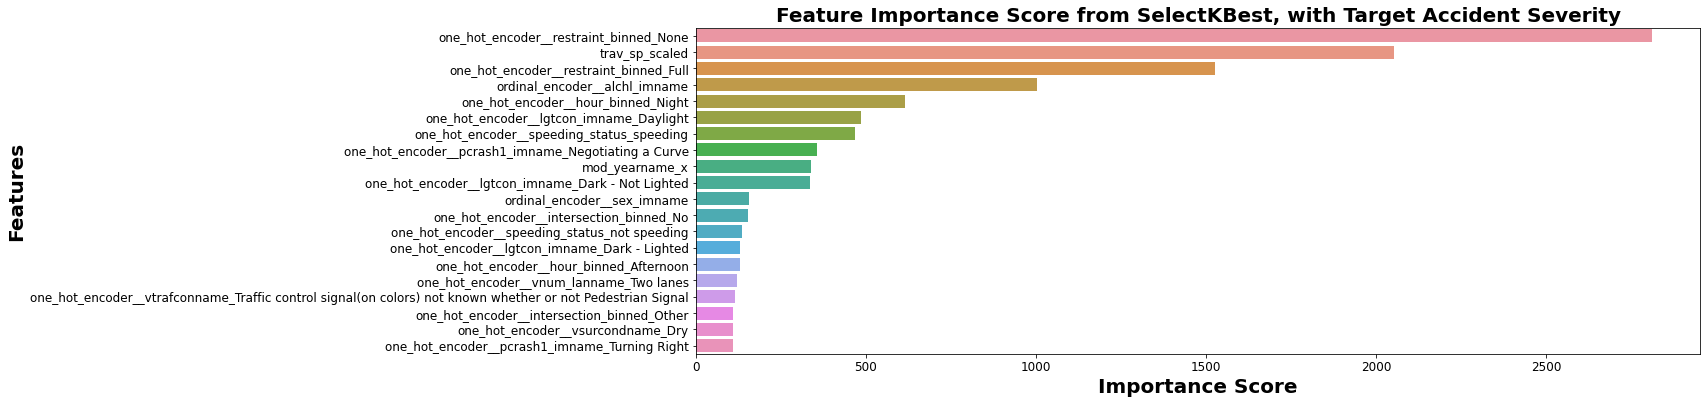

In [78]:
# code for feature selection: selectkbest

# Split the train set into X and y
X = train_pp_df.drop(columns=["maxsev_binned", "maxsev_imname"])
y = train_pp_df.loc[:, "maxsev_binned"]

# Instantiate and fit the random forest classifier
kselector = SelectKBest(k=NUM_IMPORTANCES_TO_PLOT)
kselector.fit(X, y)

# Create a dataframe of scores
kbest_scores_df = pd.DataFrame({"feature_name":kselector.feature_names_in_, 
                                  "score":kselector.scores_, 
                                  "p_value":kselector.pvalues_})


# Sort the dataframe, largest to smallest mean score
kbest_scores_df.sort_values(by="score", ascending=False, inplace=True)

# reset the index so it starts back at 1, don't keep the old index as a column
kbest_scores_df.reset_index(drop=True, inplace=True)

# Create a truncated version of the dataframe containing only the first NUM_IMPORTANCES_TO_PLOT rows
kbest_plot_df = kbest_scores_df.loc[kbest_scores_df.index < NUM_IMPORTANCES_TO_PLOT, :]

# Create a horizontal bar plot of importance scores
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
sns.barplot(y="feature_name", x="score", data=kbest_plot_df, ax=ax, orient="h")

ax.set_title("Feature Importance Score from SelectKBest, with Target Accident Severity", fontsize=20, weight=1000)
ax.set_xlabel("Importance Score", size=20, weight=1_000)
ax.set_ylabel("Features", size=20, weight=1_000)
ax.tick_params(axis='both', labelsize=12)

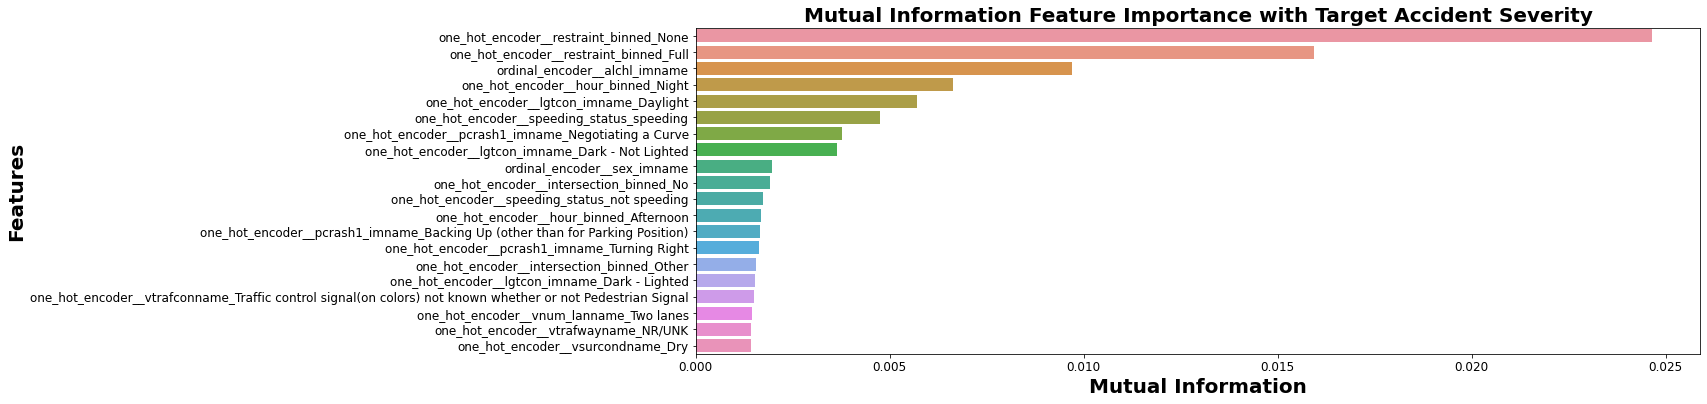

In [79]:
# code for feature selection: mutual information

# NOTE: mutual info is only considering discrete features

# Split the train set into X and y
X = train_pp_df.drop(columns=["maxsev_binned", "maxsev_imname", "age_im", "mod_yearname_x", "trav_sp_scaled"])
y = train_pp_df.loc[:, "maxsev_binned"]

# Instantiate and fit the mutual information module
mutual_info = mutual_info_classif(X=X, y=y, discrete_features=True, n_neighbors=3, random_state=42)

# Create a dataframe of scores
mutual_info_df = pd.DataFrame({"mutual_information":mutual_info, 
                               "feature_name":X.columns.tolist()})

# Sort the dataframe, largest to smallest score
mutual_info_df.sort_values(by="mutual_information", ascending=False, inplace=True)

# reset the index so it starts back at 1, don't keep the old index as a column
mutual_info_df.reset_index(drop=True, inplace=True)

# Create a truncated version of the dataframe containing only the first NUM_IMPORTANCES_TO_PLOT rows
mutual_info_plot_df = mutual_info_df.loc[mutual_info_df.index < NUM_IMPORTANCES_TO_PLOT, :]

# Create a horizontal bar plot of importance scores
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
sns.barplot(y="feature_name", x="mutual_information", data=mutual_info_plot_df, ax=ax, orient="h")

ax.set_title("Mutual Information Feature Importance with Target Accident Severity", fontsize=20, weight=1000)
ax.set_xlabel("Mutual Information", size=20, weight=1_000)
ax.set_ylabel("Features", size=20, weight=1_000)
ax.tick_params(axis='both', labelsize=12)

In [80]:
# plot?

# Data Preparation Part 2
Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).
(5)

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50535 entries, 0 to 54471
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age_im               50535 non-null  int64  
 1   alchl_imname         50535 non-null  object 
 2   hour_binned          50535 non-null  object 
 3   int_hwyname          50535 non-null  object 
 4   intersection_binned  50535 non-null  object 
 5   lgtcon_imname        50535 non-null  object 
 6   maxsev_binned        50535 non-null  object 
 7   maxsev_imname        50535 non-null  object 
 8   mod_yearname_x       50535 non-null  int64  
 9   pcrash1_imname       50535 non-null  object 
 10  regionname           50535 non-null  object 
 11  reljct1_imname       50535 non-null  object 
 12  restraint_binned     50535 non-null  object 
 13  sex_imname           50535 non-null  object 
 14  speeding_status      50535 non-null  object 
 15  trav_sp              50535 non-null 

In [83]:
display(df)

,age_im,alchl_imname,hour_binned,int_hwyname,intersection_binned,lgtcon_imname,maxsev_binned,maxsev_imname,mod_yearname_x,pcrash1_imname,...,sex_imname,speeding_status,trav_sp,urbanicityname,vnum_lanname,vsurcondname,vtrafconname,vtrafwayname,weather_binned,wkdy_imname
0,61,No Alcohol Involved,Morning,No,Yes,Daylight,Not Fatal Injury,No Apparent Injury,2018,Going Straight,...,Female,unknown,25.0,Rural,Five lanes,Snow,Traffic control signal(on colors) not known wh...,"Two-Way, Not Divided",Not Clear,Wednesday
1,23,No Alcohol Involved,Night,No,No,Dark - Not Lighted,Not Fatal Injury,Suspected Minor Injury,2013,Going Straight,...,Male,speeding,45.0,Urban,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Clear,Wednesday
3,20,No Alcohol Involved,Afternoon,Yes,No,Daylight,Not Fatal Injury,No Apparent Injury,2015,Going Straight,...,Male,not speeding,65.0,Rural,Two lanes,Snow,No Controls,"Two-Way, Divided, Positive Median Barrier",Wintery,Wednesday
7,57,No Alcohol Involved,Morning,No,Yes,Daylight,Not Fatal Injury,No Apparent Injury,2016,Stopped in Roadway,...,Male,not speeding,0.0,Rural,Five lanes,Wet,Traffic control signal(on colors) not known wh...,"Two-Way, Not Divided",Rain,Thursday
10,60,No Alcohol Involved,Morning,Yes,No,Daylight,Suspected Serious Injury,Suspected Serious Injury,2018,Going Straight,...,Male,unknown,998.0,Rural,Three lanes,Wet,No Controls,"Two-Way, Divided, Positive Median Barrier",Not Clear,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54465,25,No Alcohol Involved,Morning,No,No,Dawn,Not Fatal Injury,Possible Injury,2018,Going Straight,...,Female,unknown,998.0,Rural,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Clear,Thursday
54466,26,No Alcohol Involved,Morning,No,No,Dawn,Suspected Serious Injury,Suspected Serious Injury,2013,Going Straight,...,Male,unknown,998.0,Rural,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Not Clear,Thursday
54467,61,No Alcohol Involved,Afternoon,No,No,Daylight,Not Fatal Injury,No Apparent Injury,2017,Going Straight,...,Female,unknown,998.0,Rural,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Clear,Monday
54468,70,No Alcohol Involved,Evening,No,No,Daylight,Not Fatal Injury,Suspected Minor Injury,2019,Going Straight,...,Male,unknown,998.0,Rural,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Not Clear,Wednesday


In [84]:
# table of feature description

# Model and Evaluation 1
- Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). 
- Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.
(10)

**Classification:** 
The evaluation metric to classify driver's injury severity is F1. This is an appropriate metric because the response, injury severity, is a categorical variable. Due to the class imbalance, metrics such as accuracy is not desirable because the model could have a high no-information-rate i.e., choose the most populous category and be correct most of the time.

**Regression:**
The evaluation metric to classify driver's age is MSE. This is an appropriate metric because the response, age, is a continuous variable.

In [115]:
import re
from lightgbm import LGBMClassifier

# Split the train set into X and y
# The extra .rename() is only because LightGBM didn't like some of the characters in the column names. (brackets)
# https://stackoverflow.com/questions/60582050/lightgbmerror-do-not-support-special-json-characters-in-feature-name-the-same
X = train_pp_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)).drop(columns=["maxsev_binned", "maxsev_imname"])
y = train_pp_df.loc[:, "maxsev_binned"]

param_distributions = {'num_leaves':[21, 26, 31, 36, 41], 
                       'max_depth':[-1, 10], 
                       'learning_rate':[0.01, 0.05, 0.1, 0.15, 0.2, 0.3]}

rs_severity_lgbm = RandomizedSearchCV(estimator=LGBMClassifier(boosting_type="gbdt", random_state=42), 
                                      param_distributions=param_distributions, 
                                      n_iter=10, 
                                      scoring={'f1':make_scorer(f1_score, pos_label="Fatal"), 'accuracy': make_scorer(accuracy_score)}, 
                                      refit='f1',
                                      n_jobs=-1, 
                                      cv=10, 
                                      random_state=42, 
                                      return_train_score=True, 
                                      error_score="raise")

rs_severity_lgbm.fit(X, y)

lgbm_rs_severity_df = pd.DataFrame(rs_severity_lgbm.cv_results_)

# Sort the randomsearch results dataframe from highest to lowest test f1
lgbm_rs_severity_df.sort_values(by="mean_test_f1", ascending=False, inplace=True)

# View the randomsearch results
lgbm_rs_severity_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_max_depth,param_learning_rate,params,split0_test_f1,split1_test_f1,...,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,split5_train_accuracy,split6_train_accuracy,split7_train_accuracy,split8_train_accuracy,split9_train_accuracy,mean_train_accuracy,std_train_accuracy
5,1.224814,0.224571,0.098187,0.009085,41,-1,0.3,"{'num_leaves': 41, 'max_depth': -1, 'learning_...",0.474691,0.453608,...,0.932774,0.932802,0.931538,0.933736,0.934836,0.934643,0.930853,0.933353,0.933399,0.001362
9,1.101401,0.110237,0.091400,0.019309,31,10,0.3,"{'num_leaves': 31, 'max_depth': 10, 'learning_...",0.443686,0.441833,...,0.920352,0.920462,0.921396,0.920517,0.921396,0.919307,0.919529,0.919529,0.920086,0.000915
7,1.232597,0.091184,0.102399,0.013245,36,10,0.2,"{'num_leaves': 36, 'max_depth': 10, 'learning_...",0.428402,0.424970,...,0.911639,0.911859,0.910045,0.910128,0.912134,0.910732,0.910268,0.910597,0.911192,0.000876
6,1.180157,0.124132,0.093600,0.011696,36,-1,0.15,"{'num_leaves': 36, 'max_depth': -1, 'learning_...",0.400966,0.419277,...,0.904466,0.903092,0.902735,0.902487,0.902075,0.903587,0.902572,0.902820,0.903114,0.000722
3,1.299901,0.221496,0.096699,0.009142,21,10,0.2,"{'num_leaves': 21, 'max_depth': 10, 'learning_...",0.417983,0.400491,...,0.896111,0.894764,0.895754,0.895644,0.894737,0.894572,0.895674,0.896031,0.895348,0.000678


# Model and Evaluation 2
- Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). 
- Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.
(10)

**Classification:** 
The method used to divide the data into train and test split is xxx because xxx.

**Regression:**
The method used to divide the data into train and test split is xxx because xxx. 

In [85]:
# code to split data here

# Model and Evaluation 3
- Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). 
- Two modeling techniques must be new (but the third could be SVM or logistic regression). 
- Adjust parameters as appropriate to increase generalization performance using your chosen metric. 
- You must investigate different parameters of the algorithms!
(20)

## Classification

### Random Forest for Classification

### kNN for Classification

### SVM for Classification

## Regression

### Random Forest for Regression

### kNN for Regression

### SVM for Regression

# Model and Evaluation 4
- Analyze the results using your chosen method of evaluation. 
- Use visualizations of the results to bolster the analysis. 
- Explain any visuals and analyze why they are interesting to someone that might use this model.
(10)

We need one plot of the winning model from each task.

## Classification

## Regression

# Model and Evaluation 5
- Discuss the advantages of each model for each classification task, if any. 
- If there are not advantages, explain why. Is any model better than another? 
- Is the difference significant with 95% confidence? Use proper statistical comparison methods. 
- You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.
(10)

ROC plot of winning model from each task.

## Classification

## Regression

# Model and Evaluation 6 
- Which attributes from your analysis are most important? 
- Use proper methods discussed in class to evaluate the importance of different attributes. 
- Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.
(10)

## Classification

## Regression

# Deployment
- How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? 
- How would you measure the model's value if it was used by these parties? 
- How would your deploy your model for interested parties? 
- What other data should be collected? How often would the model need to be updated, etc.? 
(5)

1. How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? 

2. How would you measure the model's value if it was used by these parties? 


3. How would your deploy your model for interested parties? 


4. What other data should be collected? How often would the model need to be updated, etc.? 

# Exceptional Work
- You have free reign to provide additional analyses. 
- One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. 
- Which parameters are most significant for making a good model for each classification algorithm?
(10)

In [86]:
# grid search code